In [1]:
#This project was largely a learning opportunity to understand compromises between Domain-based inferences and model building
#The flow of the project will explain the train of thought to justify use of specific features for further model building,
#and defend the use of new features made on the way.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
#ensemble
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix

#warnings
import warnings
warnings.filterwarnings("ignore")

import pycalib
from pycalib import metrics
from sklearn.calibration import calibration_curve

In [3]:
df = pd.read_csv('train.csv')

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [4]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d2

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'Credit Risk'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'Employment Type'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade','Employment.Type'],axis=1)

In [5]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [6]:
numerical=['disbursed_amount','asset_cost','PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES','Age','NEW.ACCTS.IN.LAST.SIX.MONTHS', 
        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
categorical=['manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES', 'Credit Risk','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH',
       'Employment Type']

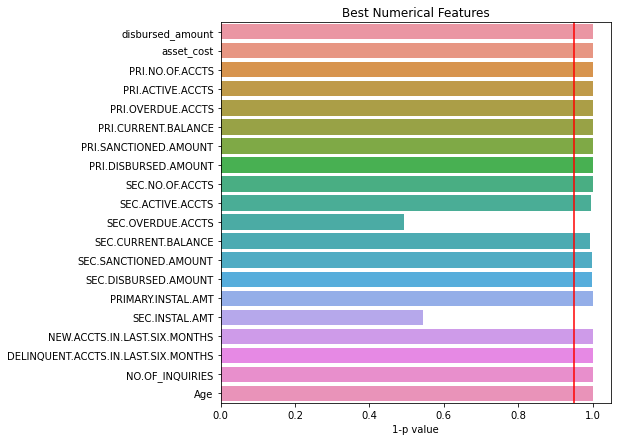

In [7]:
#T Test for numerical columns
p=[]
from scipy.stats import ttest_ind

for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    p.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05),color='r')
plt.xlabel('1-p value')
plt.show()

For visual purpose, I redid the graph to show acceptance of 'Alternative Hypothesis' for T Test. So, the ones crossing the red lines show
statistical significance. But for vehicle loans and educational loans, it is observed that Banks don't want to compromise of loosing any 
details of Secondary Account holder, since them also being the guarantor for the loan in case of a default.
But, there is a problem in this T Test, as will be observed in the next cell


In [8]:
for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    print(np.std(df1[i],ddof=1),np.std(df2[i],ddof=1))

13140.699007454981 12150.255527172329
19015.002867400774 18680.502608619492
5.261141650236005 5.04013362644165
2.0082420121201543 1.6699657272094286
0.5320262425886055 0.6034839757822386
994631.7352945457 720451.2837834031
1234346.7457205276 4525738.059420681
1240214.826412385 4527095.229863031
0.6516570890275873 0.527358347626265
0.32337474128357524 0.2880958812264165
0.1112491367023999 0.11046343401346002
184110.75765814638 106044.4250689912
195212.28973392927 130717.86808523617
194597.53945599656 130392.76612443924
157963.98513600946 124665.51133351553
16588.052553508056 11045.628444420758
0.9729689997390004 0.8856611487937556
0.37023513218495563 0.43087164170425074
0.6655358308421763 0.8351467924444976
9.837771953398061 9.65876884479994
0.9729689997390004 0.8856611487937556
0.37023513218495563 0.43087164170425074


The above observations are Standard Deviations of Columns (i.e., Defaulters vs Non-defaulters). T Test for independence runs on the assumption that samples under observations should have equal Standard Deviations. Although the difference observed above seems less, it still doesn't seem acceptable. Hence, we'll go with a non-parametric test.

We'll use SelectKBest library to narrow down choices of features. This will make use of Annova test.

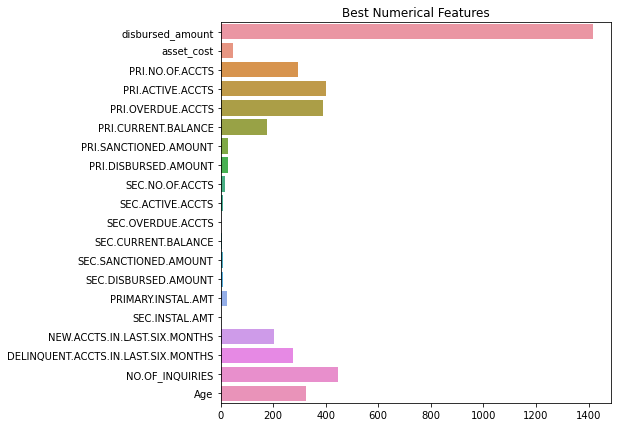

In [9]:
from sklearn.feature_selection import SelectKBest,f_classif
n = SelectKBest(score_func=f_classif, k=10)
numcols=n.fit(df[numerical],df['loan_default'])
plt.figure(figsize=(7,7))
sns.barplot(x=numcols.scores_,y=numerical)
plt.title('Best Numerical Features')
plt.show()

The graph shows that Secondary Account informations are insignificant. Again of course, banks can't afford to drop Secondary Account informations, so we'll have to combine the Primary and Secondary Account informations. 

In [10]:
df.loc[:,'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df.loc[:,'PRI Inactive accounts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'SEC Inactive accounts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'Total Inactive accounts'] = df['PRI Inactive accounts'] + df['SEC Inactive accounts']
df.loc[:,'Total Overdue Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

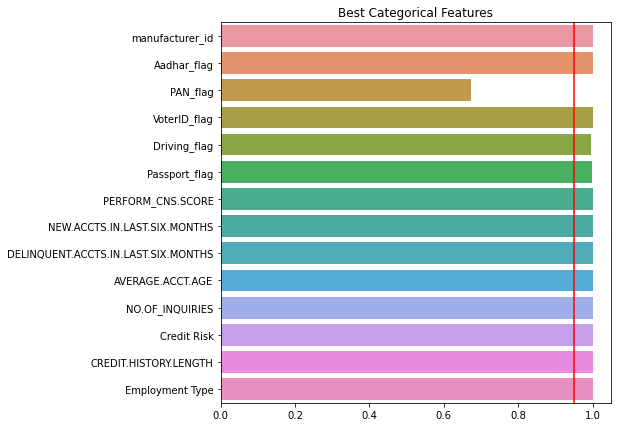

In [11]:
#Chi Square test for Categorical Columns
from scipy.stats import chi2_contingency
l=[]
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df['loan_default'],df[i]))[1]
    l.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r')
plt.show()

Here too, the graph shows acceptance of Alternate Hypothesis. Again, we can observe some multicollinearity between credit score and PAN Card,
since PAN Card is mandatory to obtain credit score. Hence, the Chi Square test deemed it surplus to our research. But for argument sake, we'll
keep it.

In [12]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [13]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [14]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','PRI Inactive accounts','SEC Inactive accounts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [15]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment','Age']

In [16]:
len(nums)

16

# LogisticRegression

In [17]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print('train accuracy :',lr.score(X_train,y_train))
print('test accuracy :',lr.score(X_test,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))

train accuracy : 0.7829443590042093
test accuracy : 0.7827783893519379
precision : 0.0 

recall : 0.0 

f1 score: 0.0 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54756
           1       0.00      0.00      0.00     15191

    accuracy                           0.78     69947
   macro avg       0.39      0.50      0.44     69947
weighted avg       0.61      0.78      0.69     69947



In [18]:
y_test

1197      1
109250    0
171069    0
227346    0
136799    0
         ..
163258    1
127079    0
203495    0
62356     0
222966    0
Name: loan_default, Length: 69947, dtype: int64

In [19]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
indexes = y_test.index.values
indexes = indexes.tolist()

In [21]:
y_true = [[] for i in range(len(indexes))]
pred = [[] for i in range(len(indexes))]
for i in range(len(indexes)):
    y_true[i] = (indexes[i], y_test.values[i])
    pred[i] = (indexes[i], y_pred[i])
# y_true
# y_pred

In [22]:
scores_lr = lr.predict_proba(X_test)
scores_lr

array([[0.86649848, 0.13350152],
       [0.72725596, 0.27274404],
       [0.73555608, 0.26444392],
       ...,
       [0.75286964, 0.24713036],
       [0.79340746, 0.20659254],
       [0.78143106, 0.21856894]])

In [23]:
# Calculate the ECE value of knnclassifier
pycalib.metrics.binary_ECE(y_test.values, scores_lr[:,1], bins=15)

0.03991678100275907

In [24]:
# brier score
pycalib.metrics.brier_score(y_test.values, y_pred)

0.2172216106480621

In [25]:
# cross-entropy (log loss)
pycalib.metrics.cross_entropy(y_test.values, y_pred)

7.5025686726101934

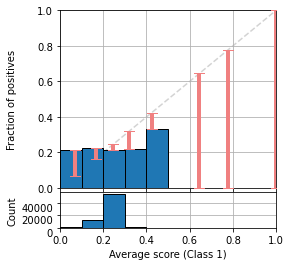

In [26]:
from pycalib.visualisations import plot_reliability_diagram

fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)


Now this is a bad start to model building. The model isn't able to predict the 1s here. Maybe class-imbalance here. Plus, there is huge difference between macro and weighted scores. So, lets see the distribution of the target variable.

<AxesSubplot:xlabel='loan_default', ylabel='count'>

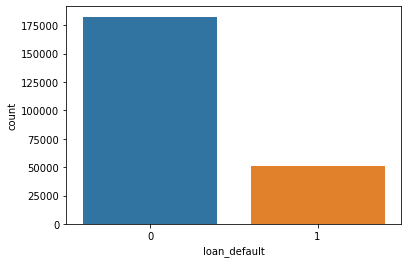

In [27]:
sns.countplot(df['loan_default'])

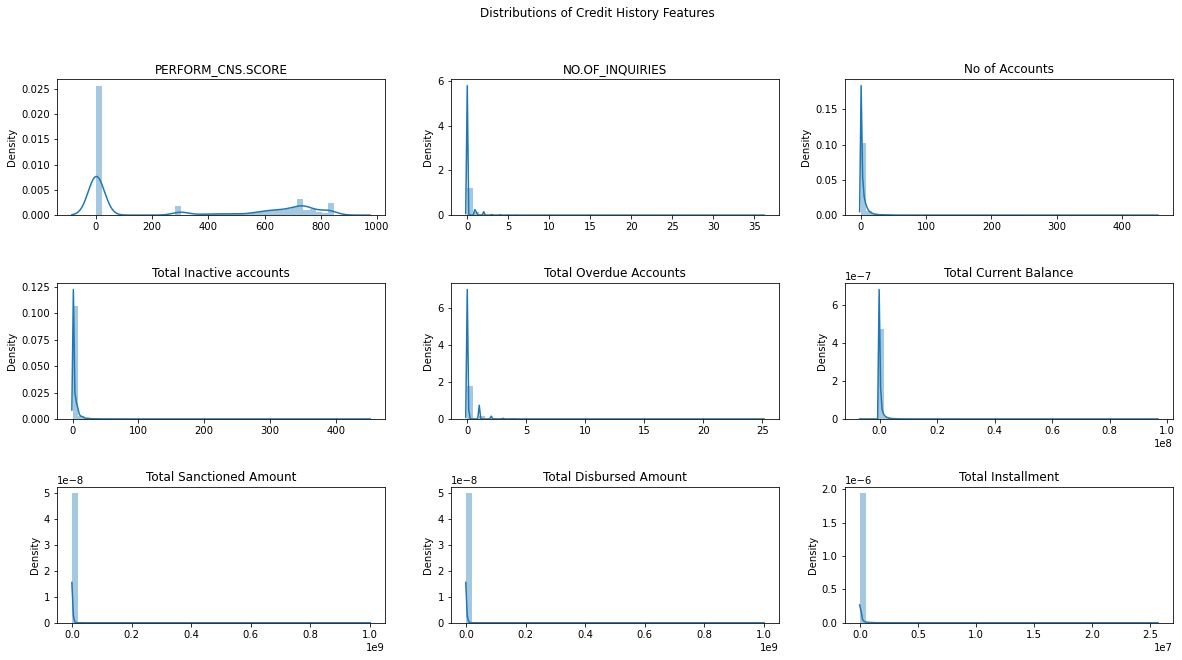

In [28]:
n=['PERFORM_CNS.SCORE','NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment']
data=df[n]
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Credit History Features')

for ax, feature, name in zip(axes.flatten(), data.values.T, data.columns):
    sns.distplot(feature, ax=ax)
    ax.set(title=str(name))
plt.show()

Maximum number of customers are applying for loan for the first time, which explains why all the above columns have so many zero values. Also, there are many notable outliers, which makes the problem more complicated.

Let's deal with outliers. Instead of using popular methods, we'll try to preserve the outlier records instead of removing them. We'll use RobustScaler to bring the observations closer to the median value (here, zero in those credit history columns).

In [29]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])

Now, for the zero observations, we'll make a new feature that counts the features having zero. This will act as yardstick between people who have a credit history and those who dont. Of course, people with no credit history will likely have more than 9 features as zero, unlikely in case of customers with credit history.

In [30]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

Now let's try on our base model. We'll use XGBoost to reduce bias and variance errors, and do some hyperparameter tuning.

In [31]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [32]:
from sklearn.model_selection import GridSearchCV

# XGBClassifier

In [33]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=3)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 6.90550828,  6.86020398,  6.67556262, 11.92811728, 11.78044669,
         11.55531724, 18.6274031 , 17.75171574, 17.50001502, 26.09456595,
         25.54979825, 19.54406468]),
  'std_fit_time': array([0.04200387, 0.07186766, 0.20957358, 0.01839339, 0.03810551,
         0.25292026, 0.11520892, 0.0879816 , 0.09510399, 0.21542955,
         0.36421746, 4.08572368]),
  'mean_score_time': array([0.04333417, 0.03985572, 0.0491604 , 0.06035773, 0.05257201,
         0.05658078, 0.07638399, 0.06900724, 0.07086404, 0.09132171,
         0.09701467, 0.08411368]),
  'std_score_time': array([0.00093103, 0.00098909, 0.00562083, 0.0030162 , 0.00145782,
         0.0027808 , 0.00689599, 0.0013699 , 0.00324282, 0.00402154,
         0.00197306, 0.01007438]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [34]:
param_test2b = {
 'max_depth':range(7,10,2)
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=3)
gsearch2b.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             n_jobs=4, param_grid={'max_depth': range(7, 10, 2)},
             scoring='roc_auc')

In [35]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([17.75371861, 18.05573869]),
  'std_fit_time': array([0.087034  , 4.28994529]),
  'mean_score_time': array([0.07282273, 0.09084129]),
  'std_score_time': array([0.00121238, 0.00015801]),
  'param_max_depth': masked_array(data=[7, 9],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 7}, {'max_depth': 9}],
  'split0_test_score': array([0.99832377, 0.99918667]),
  'split1_test_score': array([0.99783914, 0.99892714]),
  'split2_test_score': array([0.99785766, 0.99893082]),
  'mean_test_score': array([0.99800686, 0.99901488]),
  'std_test_score': array([0.00022422, 0.00012148]),
  'rank_test_score': array([2, 1], dtype=int32)},
 {'max_depth': 9},
 0.9990148765981856)

In [36]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.3}, 0.9991842464419699)

In [37]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [38]:
xgb4.fit(X_train,y_train)
y_pred2=xgb4.predict(X_test)
print("accuracy train:",xgb4.score(X_train,y_train),"\n")
print("accuracy test:",xgb4.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred2),"\n")
print("Recall :",recall_score(y_test,y_pred2),"\n")
print("f1 score:",f1_score(y_test,y_pred2),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred2))

accuracy train: 0.9999448553064513 

accuracy test: 0.9983273049594693 

precision : 0.9985447810556952 

Recall : 0.993746297149628 

f1 score: 0.9961397604671879 

Confusion Matrix 
 [[54734    22]
 [   95 15096]]


Voila! we smashed the record set on all these scores.

In [39]:
import sklearn.metrics as metrics

In [40]:
probs = xgb4.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

In [41]:
print(fpr, tpr)

[0.         0.         0.         ... 0.99877639 0.99881292 1.        ] [0.00000000e+00 6.58284511e-05 1.51405437e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


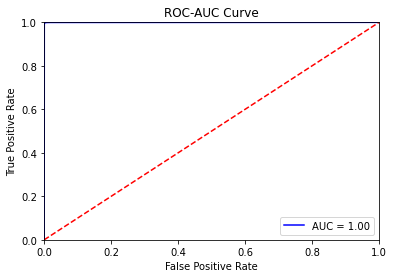

In [42]:
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()

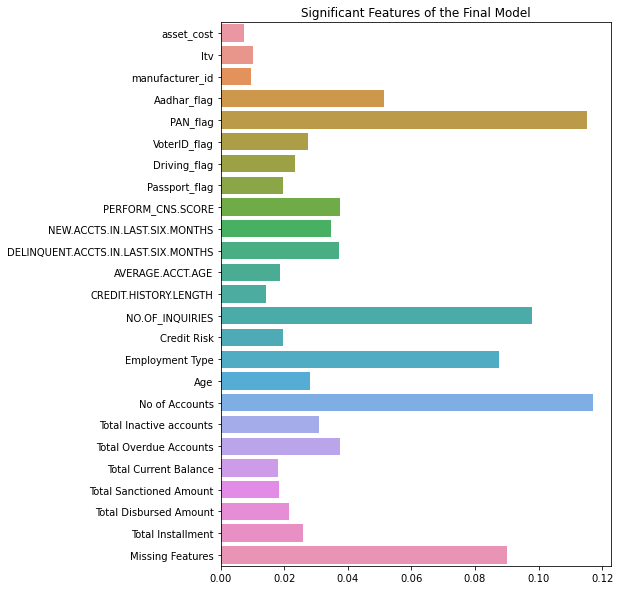

In [43]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb4.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()

In [44]:
pred2 = [[] for i in range(len(indexes))]
for i in range(len(indexes)):
    pred2[i] = (indexes[i], y_pred2[i])
pred2

[(1197, 1),
 (109250, 0),
 (171069, 0),
 (227346, 0),
 (136799, 0),
 (90689, 0),
 (44163, 1),
 (203143, 0),
 (175529, 0),
 (21348, 0),
 (64855, 0),
 (184678, 0),
 (22003, 0),
 (126636, 0),
 (44478, 0),
 (215684, 0),
 (169207, 0),
 (213245, 0),
 (182937, 0),
 (128734, 0),
 (104956, 0),
 (125975, 0),
 (98949, 0),
 (221932, 0),
 (180714, 0),
 (4729, 0),
 (161117, 0),
 (110528, 0),
 (172995, 0),
 (142602, 0),
 (93797, 0),
 (187312, 1),
 (148923, 0),
 (22519, 0),
 (140315, 0),
 (221576, 0),
 (198549, 0),
 (231807, 1),
 (117006, 1),
 (5002, 0),
 (90774, 0),
 (230315, 0),
 (11081, 0),
 (53645, 1),
 (34211, 0),
 (30074, 0),
 (220332, 0),
 (195291, 0),
 (3324, 1),
 (39416, 0),
 (116630, 0),
 (84748, 0),
 (228312, 0),
 (121577, 0),
 (12881, 0),
 (204405, 0),
 (114819, 0),
 (8282, 1),
 (101767, 0),
 (2259, 0),
 (70312, 0),
 (35522, 0),
 (116618, 0),
 (181015, 1),
 (53376, 1),
 (79491, 0),
 (119622, 1),
 (193321, 0),
 (36139, 0),
 (201831, 0),
 (202295, 0),
 (65013, 1),
 (33827, 0),
 (201804, 0),


In [45]:
pycalib.metrics.binary_ECE(y_test.values, preds, bins=15)

0.00534543501695744

In [46]:
pycalib.metrics.brier_score(y_test.values, y_pred2)

0.0016726950405306876

In [47]:
pycalib.metrics.cross_entropy(y_test.values, y_pred2)

0.05777309147423169

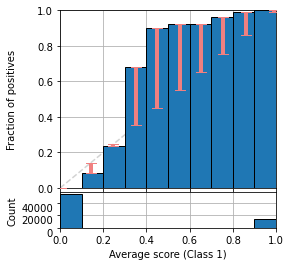

In [48]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [probs, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)


# Reliability Diagram

In [49]:
classifiers = {"Logistic Regression": lr,
               "XGB": xgb4}

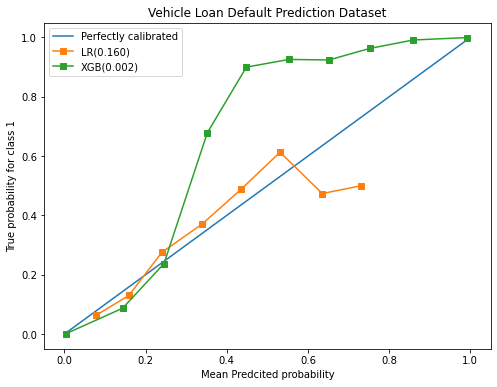

In [50]:
from sklearn.datasets import make_classification as mc
from sklearn.metrics import brier_score_loss # 导入布里尔分数
from sklearn.calibration import calibration_curve # 对概率类模型进行校准，方法是分箱

model = ["LR", "XGB"]
#开始画图
fig,ax1 = plt.subplots(figsize = (8,6))
ax1.plot([0,1],[0,1],label = "Perfectly calibrated") # 绘制对角线，把（0，0），（1，1）连起来
for clf,name_ in zip([lr, xgb4],model):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf,"predict_proba"): #对象里如果有这个接口
        prob_pos = clf.predict_proba(X_test)[:,1]
    else: #就是针对SVM
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos-prob_pos.min())/(prob_pos.max()-prob_pos.min())  #手动归一化
    clf_score = brier_score_loss(y_test,prob_pos,pos_label=y.max())
    #对只有0，1的标签值进行分箱后才能画图
    trueproba, predproba = calibration_curve(y_test, prob_pos, n_bins=10)
    ax1.plot(predproba,trueproba,"s-",label = "%s(%1.3f)"%(name_,clf_score))
    ax1.set_ylabel("True probability for class 1")
    ax1.set_xlabel("Mean Predcited probability")
    ax1.set_ylim([-0.05,1.05])
    ax1.legend()
plt.title('Vehicle Loan Default Prediction Dataset')
plt.savefig('rd3.png')
plt.show()

# Hypothesis Testing

In [51]:
from scipy.stats import percentileofscore
from sklearn.preprocessing import label_binarize
import numpy as np

def label_resampling(probs):
    return np.random.binomial(1, probs)

def score_sampling(probs, samples = 10000, ece_function = None):
    probs = np.array(probs)
    return np.array(
        [
            ece_function(label_resampling(probs), probs) for sample in range(samples)
        ]
    )

def pECE(y_true, probs, samples = 10000, ece_function = pycalib.metrics.binary_ECE):
    probs = np.array(probs)
    return 1 - (
        percentileofscore(
            score_sampling(
                probs,
                samples=samples,
                ece_function=ece_function
            ),
            ece_function(y_true, probs)
        ) / 100
    )

In [52]:
pECE(y_test, scores_lr[:,1])

0.0

In [53]:
pECE(y_test, probs[:,1])

0.0

# Calibration

In [54]:
from __future__ import division
import numpy as np

from scipy.special import expit

from sklearn.base import clone
from sklearn.utils import check_X_y, indexable
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import _SigmoidCalibration
from sklearn.metrics import log_loss

import warnings

from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from inspect import signature
from sklearn.isotonic import IsotonicRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import check_cv


from betacal import BetaCalibration


class _DummyCalibration(BaseEstimator, RegressorMixin):
    """Dummy Calibration model. The purpose of this class is to give
    the CalibratedClassifierCV class the option to just return the
    probabilities of the base classifier.
    """
    def fit(self, *args, **kwargs):
        """Does nothing"""
        return self

    def predict_proba(self, T):
        """Return the probabilities of the base classifier"""
        return T

    def predict(self, scores, *args, **kwargs):
        proba = self.predict_proba(scores, *args, **kwargs)
        return proba.argmax(axis=1)


class IsotonicCalibration(IsotonicRegression):
    def __init__(self):
        super(IsotonicCalibration, self).__init__(y_min=0.0, y_max=1.0,
                                                  increasing=True,
                                                  out_of_bounds='clip')

    def fit(self, scores, y, *args, **kwargs):
        '''
        Score=0 corresponds to y=0, and score=1 to y=1
        Parameters
        ----------
        scores : array-like, shape = [n_samples,]
            Data.
        y : array-like, shape = [n_samples, ]
            Labels.
        Returns
        -------
        self
        '''
        if len(scores.shape) > 1:
            scores = scores[:, 1]
        return super(IsotonicCalibration, self).fit(scores, y, *args, **kwargs)

    def predict_proba(self, scores, *args, **kwargs):
        if len(scores.shape) > 1:
            scores = scores[:, 1]
        transformed = self.transform(scores, *args, **kwargs)
        if len(transformed.shape) == 1:
            transformed = np.vstack((1 - transformed, transformed)).T
        return transformed

    def predict(self, scores, *args, **kwargs):
        proba = self.predict_proba(scores, *args, **kwargs)
        return proba.argmax(axis=1)


def logit(x):
    eps = np.finfo(x.dtype).eps
    x = np.clip(x, eps, 1-eps)
    return np.log(x/(1 - x))


def log_encode(x):
    eps = np.finfo(x.dtype).eps
    x = np.clip(x, eps, 1)
    return np.log(x)


class LogisticCalibration(LogisticRegression):
    def __init__(self, C=1.0, solver='lbfgs', multi_class='multinomial',
                 log_transform=True):
        self.C_grid = C
        self.C = C if isinstance(C, float) else C[0]
        self.solver = solver
        self.log_transform = log_transform
        self.encode = log_encode if log_transform else logit
        self.multiclass = multi_class
        super(LogisticCalibration, self).__init__(C=C, solver=solver,
                                                  multi_class=multi_class)

    def fit(self, scores, y, X_val=None, y_val=None, *args, **kwargs):
        if isinstance(self.C_grid, list):
            calibrators = []
            losses = np.zeros(len(self.C_grid))
            for i, C in enumerate(self.C_grid):
                cal = LogisticCalibration(C=C, solver=self.solver,
                                          multi_class=self.multi_class,
                                          log_transform=self.log_transform)
                cal.fit(scores, y)
                losses[i] = log_loss(y_val, cal.predict_proba(X_val))
                calibrators.append(cal)
            best_idx = losses.argmin()
            self.C = calibrators[best_idx].C
        return super(LogisticCalibration, self).fit(self.encode(scores), y,
                                                    *args, **kwargs)

    def predict_proba(self, scores, *args, **kwargs):
        return super(LogisticCalibration,
                     self).predict_proba(self.encode(scores), *args, **kwargs)

    def predict(self, scores, *args, **kwargs):
        return super(LogisticCalibration, self).predict(self.encode(scores),
                                                        *args, **kwargs)


class SigmoidCalibration(_SigmoidCalibration):
    def fit(self, scores, y, *args, **kwargs):
        if len(scores.shape) > 1:
            scores = scores[:, 1]
        return super(SigmoidCalibration, self).fit(scores, y, *args, **kwargs)

    def predict_proba(self, scores, *args, **kwargs):
        if len(scores.shape) > 1:
            scores = scores[:, 1]
        transformed = super(SigmoidCalibration, self).predict(scores, *args, **kwargs)
        return np.vstack((1 - transformed, transformed)).T

    def predict(self, *args, **kwargs):
        proba = self.predict_proba(*args, **kwargs)
        return proba.argmax(axis=1)


class BinningCalibration(BaseEstimator, RegressorMixin):
    def __init__(self, n_bins=10, strategy='uniform', alpha=1.0):
        '''
        alpha : Laplace smoothing (x + a)/(N + 2a)
        n_bins: Number of bins
        stragegy:
                - uniform: for equal width bins
                - quantile: for equal frequency bins
                - kmeans: for each bin with same nearest center to a 1D k-means
        '''
        self.strategy = strategy
        self.n_bins = n_bins
        self.n_bins_grid = n_bins
        self.alpha = alpha

    def fit(self, scores, y, X_val=None, y_val=None, *args, **kwargs):
        '''
        Score=0 corresponds to y=0, and score=1 to y=1
        Parameters
        ----------
        scores : array-like, shape = [n_samples,]
            Data.
        y : array-like, shape = [n_samples, ]
            Labels.
        Returns
        -------
        self
        '''
        if isinstance(self.n_bins, list):
            if X_val is None or y_val is None:
                raise ValueError(('If n_bins is a list, scores_val and y_val'
                                  'are required during fit'))
            calibrators = []
            losses = []
            for n_bins in self.n_bins:
                cal = BinningCalibration(n_bins=n_bins, strategy=self.strategy,
                                         alpha=self.alpha)
                cal.fit(scores, y)
                predict = cal.predict_proba(X_val)
                losses.append(log_loss(y_val, predict))
                calibrators.append(cal)
            best_idx = np.argmin(losses)
            self.n_bins = calibrators[best_idx].n_bins
            self.bins = calibrators[best_idx].bins
            self.predictions = calibrators[best_idx].predictions
            return self

        if len(np.shape(scores)) > 1:
            scores = scores[:, 1]
        # TODO check that this code is correct:
        if self.strategy == 'quantile':
            self.bins = np.sort(scores)[::int(np.ceil(len(scores)
                                                      / self.n_bins))]
            self.bins = np.hstack([self.bins, scores[-1]])
        elif self.strategy == 'uniform':
            self.bins = np.linspace(scores.min(), scores.max(), self.n_bins+1)
        else:
            raise ValueError('Strategy {} not implemented'.format(
                                 self.strategy))
        self.bins[0] = - np.inf
        self.bins[-1] = np.inf
        s_binned = np.digitize(scores, self.bins) - 1
        self.predictions = np.zeros(self.n_bins)
        for i in range(self.n_bins):
            self.predictions[i] = ((np.sum(y[s_binned == i]) + self.alpha)
                                   / (np.sum(s_binned == i) + self.alpha*2))

        return self

    def predict_proba(self, scores, *args, **kwargs):
        if len(np.shape(scores)) > 1:
            scores = scores[:, 1]
        s_binned = np.digitize(scores, self.bins) - 1
        transformed = self.predictions[s_binned]
        return np.vstack((1 - transformed, transformed)).T

    def predict(self, scores, *args, **kwargs):
        proba = self.predict_proba(scores, *args, **kwargs)
        return proba.argmax(axis=1)


class CalibratedModel(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, calibrator=None,
                 fit_estimator=True):
        ''' Initialize a Calibrated model (classifier + calibrator)
        Parameters
        ----------
        base_estimator : estimator
            Classifier instance
        calibrator : estimator
            Calibrator instance
        '''
        self.calibrator = clone(calibrator)
        self.base_estimator = clone(base_estimator)
        self.fit_estimator = fit_estimator
        self.binary = False

    def fit(self, X, y, X_val=None, y_val=None, *args, **kwargs):
        """Fit the calibrated model
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        y : array-like, shape (n_samples, n_classes)
            Target values.
        Returns
        -------
        self : object
            Returns an instance of self.
        """

        X, y = check_X_y(X, y, accept_sparse=['csc', 'csr', 'coo'],
                         multi_output=True)
        X, y = indexable(X, y)

        if self.fit_estimator:
            self.base_estimator.fit(X, y)

        scores = self.base_estimator.predict_proba(X)

        if scores.shape[1] == 2:
            self.binary = True

        if self.binary:
            try:
                self.calibrator.fit(scores, y, *args, **kwargs)
            except ValueError:
                self.calibrator.fit(scores[:, 1], y, *args, **kwargs)
        else:
            self.calibrator.fit(scores, y, *args, **kwargs)

        return self

    def predict_proba(self, X):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas. Can be exact zeros.
        """

        scores = self.base_estimator.predict_proba(X)

        if self.binary:
            try:
                predictions = self.calibrator.predict_proba(scores)
            except ValueError:
                predictions = self.calibrator.predict_proba(scores[:, 1])

            if (len(predictions.shape) == 1) or (predictions.shape[1] == 1):
                predictions = np.vstack((1 - predictions, predictions)).T
        else:
            predictions = self.calibrator.predict_proba(scores)

        return predictions

    def predict(self, X):
        """Predict the target of new samples. Can be different from the
        prediction of the uncalibrated classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples,)
            The predicted class.
        """
        check_is_fitted(self, ["calibrator"])

        return np.argmax(self.predict_proba(X), axis=1)


class CalibratedClassifierCV(BaseEstimator, ClassifierMixin):
    """Probability calibration with isotonic regression, sigmoid or beta.
    With this class, the base_estimator is fit on the train set of the
    cross-validation generator and the test set is used for calibration.
    The probabilities for each of the folds are then averaged
    for prediction. In case cv="prefit" is passed to __init__,
    it is assumed that base_estimator has been
    fitted already and all data is used for calibration. Note that
    data for fitting the classifier and for calibrating it must be disjoint.
    Read more in the :ref:`User Guide <calibration>`.
    Parameters
    ----------
    base_estimator : instance BaseEstimator
        The classifier whose output decision function needs to be calibrated
        to offer more accurate predict_proba outputs. If cv=prefit, the
        classifier must have been fit already on data.
    method : None, 'sigmoid', 'isotonic', 'beta', 'beta_am' or 'beta_ab'
        The method to use for calibration. Can be 'sigmoid' which
        corresponds to Platt's method, 'isotonic' which is a
        non-parameteric approach or 'beta', 'beta_am' or 'beta_ab' which
        correspond to three different beta calibration methods. It is
        not advised to use  isotonic  calibration with too few calibration
        samples ``(<<1000)`` since it tends to overfit.
        Use beta models in this case.
    cv : integer, cross-validation generator, iterable or "prefit", optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
        - None, to use the default 3-fold cross-validation,
        - integer, to specify the number of folds.
        - An object to be used as a cross-validation generator.
        - An iterable yielding train/test splits.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If ``y`` is neither binary nor
        multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.
        If "prefit" is passed, it is assumed that base_estimator has been
        fitted already and all data is used for calibration.
    Attributes
    ----------
    classes_ : array, shape (n_classes)
        The class labels.
    calibrated_classifiers_: list (len() equal to cv or 1 if cv == "prefit")
        The list of calibrated classifiers, one for each cross-validation fold,
        which has been fitted on all but the validation fold and calibrated
        on the validation fold.
    References
    ----------
    .. [1] Obtaining calibrated probability estimates from decision trees
           and naive Bayesian classifiers, B. Zadrozny & C. Elkan, ICML 2001
    .. [2] Transforming Classifier Scores into Accurate Multiclass
           Probability Estimates, B. Zadrozny & C. Elkan, (KDD 2002)
    .. [3] Probabilistic Outputs for Support Vector Machines and Comparisons to
           Regularized Likelihood Methods, J. Platt, (1999)
    .. [4] Predicting Good Probabilities with Supervised Learning,
           A. Niculescu-Mizil & R. Caruana, ICML 2005
    """
    def __init__(self, base_estimator=None, method=None, cv=3,
                 score_type=None):
        self.base_estimator = base_estimator
        self.method = method
        self.cv = cv
        self.score_type = score_type

    def fit(self, X, y, sample_weight=None):
        """Fit the calibrated model
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        y : array-like, shape (n_samples,)
            Target values.
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted.
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        X, y = check_X_y(X, y, accept_sparse=['csc', 'csr', 'coo'],
                         force_all_finite=False)
        X, y = indexable(X, y)
        lb = LabelBinarizer().fit(y)
        self.classes_ = lb.classes_

        # Check that each cross-validation fold can have at least one
        # example per class
        n_folds = self.cv if isinstance(self.cv, int) \
            else self.cv.n_folds if hasattr(self.cv, "n_folds") else None
        if n_folds and \
           np.any([np.sum(y == class_) < n_folds for class_ in self.classes_]):
            raise ValueError("Requesting %d-fold cross-validation but provided"
                             " less than %d examples for at least one class."
                             % (n_folds, n_folds))

        self.calibrated_classifiers_ = []
        if self.base_estimator is None:
            # we want all classifiers that don't expose a random_state
            # to be deterministic (and we don't want to expose this one).
            base_estimator = LinearSVC(random_state=0)
        else:
            base_estimator = self.base_estimator

        if self.cv == "prefit":
            calibrated_classifier = _CalibratedClassifier(
                base_estimator, method=self.method, score_type=self.score_type)
            if sample_weight is not None:
                calibrated_classifier.fit(X, y, sample_weight)
            else:
                calibrated_classifier.fit(X, y)
            self.calibrated_classifiers_.append(calibrated_classifier)
        else:
            cv = check_cv(self.cv, y, classifier=True)
            fit_parameters = signature(base_estimator.fit).parameters
            estimator_name = type(base_estimator).__name__
            if (sample_weight is not None
                    and "sample_weight" not in fit_parameters):
                warnings.warn("%s does not support sample_weight. Samples"
                              " weights are only used for the calibration"
                              " itself." % estimator_name)
                base_estimator_sample_weight = None
            else:
                base_estimator_sample_weight = sample_weight
            for train, test in cv.split(X, y):
                this_estimator = clone(base_estimator)
                if base_estimator_sample_weight is not None:
                    this_estimator.fit(
                        X[train], y[train],
                        sample_weight=base_estimator_sample_weight[train])
                else:
                    this_estimator.fit(X[train], y[train])

                calibrated_classifier = _CalibratedClassifier(
                    this_estimator, method=self.method,
                    score_type=self.score_type)
                if sample_weight is not None:
                    calibrated_classifier.fit(X[test], y[test],
                                              sample_weight[test])
                else:
                    calibrated_classifier.fit(X[test], y[test])
                self.calibrated_classifiers_.append(calibrated_classifier)

        return self

    def predict_proba(self, X):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas.
        """
        check_is_fitted(self, ["classes_", "calibrated_classifiers_"])
        X = check_array(X, accept_sparse=['csc', 'csr', 'coo'],
                        force_all_finite=False)
        # Compute the arithmetic mean of the predictions of the calibrated
        # classfiers
        mean_proba = np.zeros((X.shape[0], len(self.classes_)))
        for calibrated_classifier in self.calibrated_classifiers_:
            proba = calibrated_classifier.predict_proba(X)
            mean_proba += proba

        mean_proba /= len(self.calibrated_classifiers_)

        return mean_proba

    def calibrate_scores(self, df):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas.
        """
        check_is_fitted(self, ["classes_", "calibrated_classifiers_"])
        # Compute the arithmetic mean of the predictions of the calibrated
        # classifiers
        df = df.reshape(-1, 1)
        mean_proba = np.zeros((len(df), len(self.classes_)))
        for calibrated_classifier in self.calibrated_classifiers_:
            proba = calibrated_classifier.calibrate_scores(df)
            mean_proba += proba

        mean_proba /= len(self.calibrated_classifiers_)

        return mean_proba

    def predict(self, X):
        """Predict the target of new samples. Can be different from the
        prediction of the uncalibrated classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples,)
            The predicted class.
        """
        check_is_fitted(self, ["classes_", "calibrated_classifiers_"])
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]


class _CalibratedClassifier(object):
    """Probability calibration with isotonic regression or sigmoid.
    It assumes that base_estimator has already been fit, and trains the
    calibration on the input set of the fit function. Note that this class
    should not be used as an estimator directly. Use CalibratedClassifierCV
    with cv="prefit" instead.
    Parameters
    ----------
    base_estimator : instance BaseEstimator
        The classifier whose output decision function needs to be calibrated
        to offer more accurate predict_proba outputs. No default value since
        it has to be an already fitted estimator.
    method : 'sigmoid' | 'isotonic' | 'beta' | 'beta_am' | 'beta_ab'
        The method to use for calibration. Can be 'sigmoid' which
        corresponds to Platt's method, 'isotonic' which is a
        non-parameteric approach based on isotonic regression or 'beta',
        'beta_am' or 'beta_ab' which correspond to beta calibration methods.
    References
    ----------
    .. [1] Obtaining calibrated probability estimates from decision trees
           and naive Bayesian classifiers, B. Zadrozny & C. Elkan, ICML 2001
    .. [2] Transforming Classifier Scores into Accurate Multiclass
           Probability Estimates, B. Zadrozny & C. Elkan, (KDD 2002)
    .. [3] Probabilistic Outputs for Support Vector Machines and Comparisons to
           Regularized Likelihood Methods, J. Platt, (1999)
    .. [4] Predicting Good Probabilities with Supervised Learning,
           A. Niculescu-Mizil & R. Caruana, ICML 2005
    """
    def __init__(self, base_estimator, method='beta',
                 score_type=None):
        self.base_estimator = base_estimator
        self.method = method
        self.score_type = score_type

    def _preproc(self, X):
        n_classes = len(self.classes_)
        if self.score_type is None:
            if hasattr(self.base_estimator, "decision_function"):
                df = self.base_estimator.decision_function(X)
                if df.ndim == 1:
                    df = df[:, np.newaxis]
            elif hasattr(self.base_estimator, "predict_proba"):
                df = self.base_estimator.predict_proba(X)
                if n_classes == 2:
                    df = df[:, 1:]
            else:
                raise RuntimeError('classifier has no decision_function or '
                                   'predict_proba method.')
        else:
            if self.score_type == "sigmoid":
                df = self.base_estimator.decision_function(X)
                df = expit(df)
                if df.ndim == 1:
                    df = df[:, np.newaxis]
            else:
                if hasattr(self.base_estimator, self.score_type):
                    df = getattr(self.base_estimator, self.score_type)(X)
                    if self.score_type == "decision_function":
                        if df.ndim == 1:
                            df = df[:, np.newaxis]
                    elif self.score_type == "predict_proba":
                        if n_classes == 2:
                            df = df[:, 1:]
                else:
                    raise RuntimeError('classifier has no ' + self.score_type
                                       + 'method.')

        idx_pos_class = np.arange(df.shape[1])

        return df, idx_pos_class

    def fit(self, X, y, sample_weight=None):
        """Calibrate the fitted model
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        y : array-like, shape (n_samples,)
            Target values.
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted.
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        lb = LabelBinarizer()
        Y = lb.fit_transform(y)
        self.classes_ = lb.classes_

        df, idx_pos_class = self._preproc(X)
        self.calibrators_ = []

        for k, this_df in zip(idx_pos_class, df.T):
            if self.method is None:
                calibrator = _DummyCalibration()
            elif self.method == 'isotonic':
                calibrator = IsotonicRegression(out_of_bounds='clip')
            elif self.method == 'sigmoid':
                calibrator = _SigmoidCalibration()
            # TODO Remove BetaCalibration
            elif self.method == 'beta':
                calibrator = BetaCalibration(parameters="abm")
            elif self.method == 'beta_am':
                calibrator = BetaCalibration(parameters="am")
            elif self.method == 'beta_ab':
                calibrator = BetaCalibration(parameters="ab")
            else:
                raise ValueError('method should be None, "sigmoid", '
                                 '"isotonic", "beta", "beta2" or "beta05". '
                                 'Got %s.' % self.method)
            calibrator.fit(this_df, Y[:, k], sample_weight)
            self.calibrators_.append(calibrator)

        return self

    def predict_proba(self, X):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas. Can be exact zeros.
        """
        n_classes = len(self.classes_)
        proba = np.zeros((X.shape[0], n_classes))

        df, idx_pos_class = self._preproc(X)
        for k, this_df, calibrator in \
                zip(idx_pos_class, df.T, self.calibrators_):
            if n_classes == 2:
                k += 1
            proba[:, k] = calibrator.predict(this_df)

        # Normalize the probabilities
        if n_classes == 2:
            proba[:, 0] = 1. - proba[:, 1]
        else:
            proba /= np.sum(proba, axis=1)[:, np.newaxis]

        # XXX : for some reason all probas can be 0
        proba[np.isnan(proba)] = 1. / n_classes

        # Deal with cases where the predicted probability minimally exceeds 1.0
        proba[(1.0 < proba) & (proba <= 1.0 + 1e-5)] = 1.0

        return proba

    def calibrate_scores(self, df):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas. Can be exact zeros.
        """
        n_classes = len(self.classes_)
        proba = np.zeros((len(df), n_classes))
        idx_pos_class = [0]

        for k, this_df, calibrator in \
                zip(idx_pos_class, df.T, self.calibrators_):
            if n_classes == 2:
                k += 1
            pro = calibrator.predict(this_df)
            if np.any(np.isnan(pro)):
                pro[np.isnan(pro)] = calibrator.predict(this_df[np.isnan(
                    pro)] + 1e-300)
            proba[:, k] = pro

        # Normalize the probabilities
        if n_classes == 2:
            proba[:, 0] = 1. - proba[:, 1]
        else:
            proba /= np.sum(proba, axis=1)[:, np.newaxis]

        # XXX : for some reason all probas can be 0
        proba[np.isnan(proba)] = 1. / n_classes

        # Deal with cases where the predicted probability minimally exceeds 1.0
        proba[(1.0 < proba) & (proba <= 1.0 + 1e-5)] = 1.0
        return proba

In [55]:
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve

## 1. LR

In [56]:
# sigmoid
cal_lr_sigm = CalibratedClassifierCV(lr, cv="prefit", method='sigmoid')
cal_lr_sigm.fit(X_test, y_test)
scores_lr_sigm = cal_lr_sigm.predict_proba(X_test)

# Cross-validated Calibration
cal_lr_sigm_cv = CalibratedClassifierCV(lr, method='sigmoid')
cal_lr_sigm_cv.fit(X_train, y_train)
scores_lr_sigm_cv = cal_lr_sigm_cv.predict_proba(X_test)

# isotonic
cal_lr_iso = CalibratedClassifierCV(lr, cv="prefit", method='isotonic')
cal_lr_iso.fit(X_test, y_test)
scores_lr_iso = cal_lr_iso.predict_proba(X_test)

# Cross-validated Calibration
cal_lr_iso_cv = CalibratedClassifierCV(lr, method='isotonic')
cal_lr_iso_cv.fit(X_train, y_train)
scores_lr_iso_cv = cal_lr_iso_cv.predict_proba(X_test)

# beta
cal_lr_beta = CalibratedClassifierCV(lr, method='beta')
cal_lr_beta.fit(X_train, y_train)
scores_lr_beta = cal_lr_beta.predict_proba(X_test)

# Cross-validated Calibration
cal_lr_beta_cv = CalibratedClassifierCV(lr, cv="prefit", method='beta')
cal_lr_beta_cv.fit(X_test, y_test)
scores_lr_beta_cv = cal_lr_beta_cv.predict_proba(X_test)

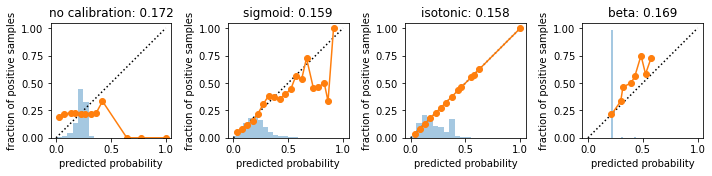

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for name, s, ax in zip(['no calibration', 'sigmoid', 'isotonic', 'beta'],
                       [scores_lr[:, 1], scores_lr_sigm[:, 1], scores_lr_iso[:, 1], scores_lr_beta[:, 1]], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

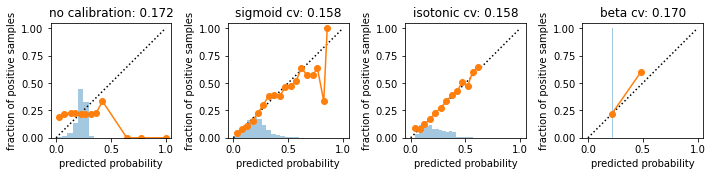

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for name, s, ax in zip(['no calibration', 'sigmoid cv', 'isotonic cv', 'beta cv'],
                       [scores_lr[:, 1], scores_lr_sigm_cv[:, 1], scores_lr_iso_cv[:, 1], scores_lr_beta_cv[:, 1]], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

In [59]:
pECE(y_test, scores_lr_sigm[:,1])

0.0

In [60]:
pECE(y_test, scores_lr_sigm_cv[:,1])

0.0

In [61]:
pECE(y_test, scores_lr_iso[:,1])

1.0

In [62]:
pECE(y_test, scores_lr_iso_cv[:,1])

0.013499999999999956

In [63]:
pECE(y_test, scores_lr_beta[:,1])

0.0928

In [64]:
pECE(y_test, scores_lr_beta_cv[:,1])

0.8746

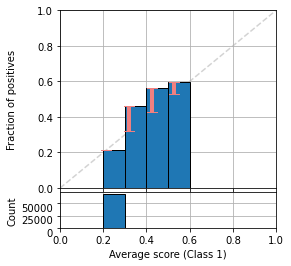

In [65]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_beta, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

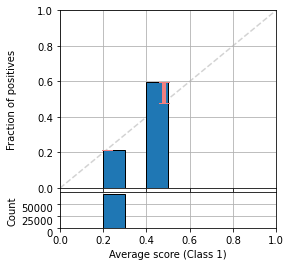

In [66]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_beta_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

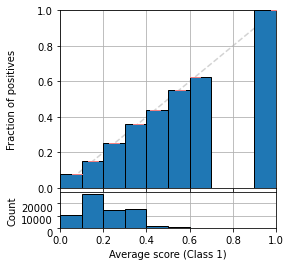

In [67]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_iso, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

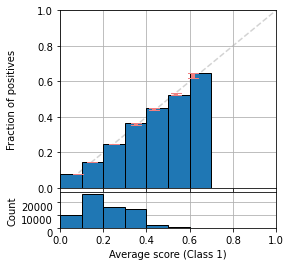

In [68]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_iso_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

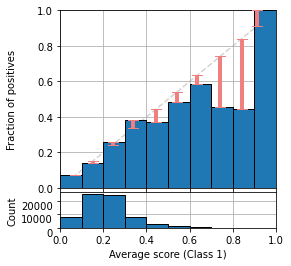

In [69]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_sigm, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

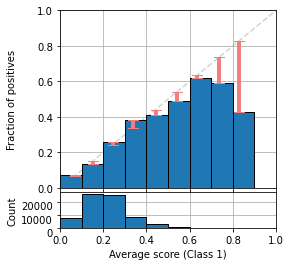

In [70]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_sigm_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

## 2. XGB

In [71]:
# sigmoid
cal_xgb_sigm = CalibratedClassifierCV(xgb4, cv="prefit", method='sigmoid')
cal_xgb_sigm.fit(X_test, y_test)
scores_xgb_sigm = cal_xgb_sigm.predict_proba(X_test)

# Cross-validated Calibration
cal_xgb_sigm_cv = CalibratedClassifierCV(xgb4, method='sigmoid')
cal_xgb_sigm_cv.fit(X_train, y_train)
scores_xgb_sigm_cv = cal_xgb_sigm_cv.predict_proba(X_test)

# isotonic
cal_xgb_iso = CalibratedClassifierCV(xgb4, cv="prefit", method='isotonic')
cal_xgb_iso.fit(X_test, y_test)
scores_xgb_iso = cal_xgb_iso.predict_proba(X_test)

# Cross-validated Calibration
cal_xgb_iso_cv = CalibratedClassifierCV(xgb4, method='isotonic')
cal_xgb_iso_cv.fit(X_train, y_train)
scores_xgb_iso_cv = cal_xgb_iso_cv.predict_proba(X_test)

# beta
cal_xgb_beta = CalibratedClassifierCV(xgb4, method='beta')
cal_xgb_beta.fit(X_train, y_train)
scores_xgb_beta = cal_xgb_beta.predict_proba(X_test)

# Cross-validated Calibration
cal_xgb_beta_cv = CalibratedClassifierCV(xgb4, cv="prefit", method='beta')
cal_xgb_beta_cv.fit(X_test, y_test)
scores_xgb_beta_cv = cal_xgb_beta_cv.predict_proba(X_test)

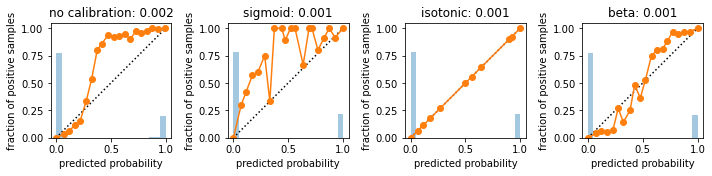

In [72]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for name, s, ax in zip(['no calibration', 'sigmoid', 'isotonic', 'beta'],
                       [probs[:, 1], scores_xgb_sigm[:, 1], scores_xgb_iso[:, 1], scores_xgb_beta[:, 1]], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

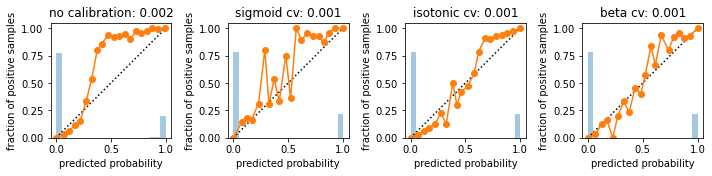

In [73]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for name, s, ax in zip(['no calibration', 'sigmoid cv', 'isotonic cv', 'beta cv'],
                       [probs[:, 1], scores_xgb_sigm_cv[:, 1], scores_xgb_iso_cv[:, 1], scores_xgb_beta_cv[:, 1]], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

In [74]:
pECE(y_test, scores_xgb_sigm[:,1])

0.0

In [75]:
pECE(y_test, scores_xgb_sigm_cv[:,1])

0.0

In [76]:
pECE(y_test, scores_xgb_iso[:,1])

1.0

In [77]:
pECE(y_test, scores_xgb_iso_cv[:,1])

0.0008000000000000229

In [78]:
pECE(y_test, scores_xgb_beta[:,1])

0.0

In [79]:
pECE(y_test, scores_xgb_beta_cv[:,1])

0.5618000000000001

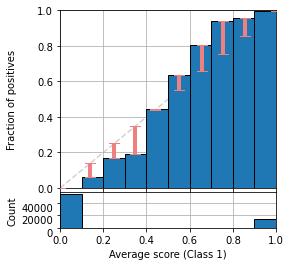

In [80]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_xgb_beta, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

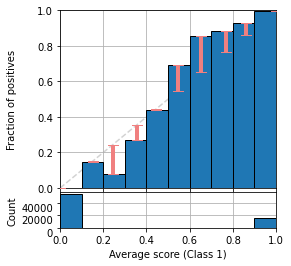

In [81]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_xgb_beta_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

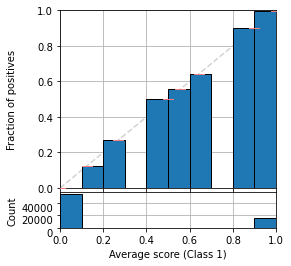

In [82]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_xgb_iso, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

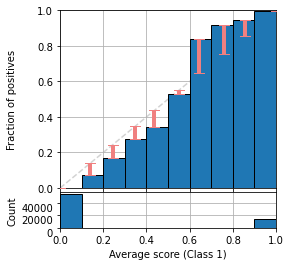

In [83]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_xgb_iso_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

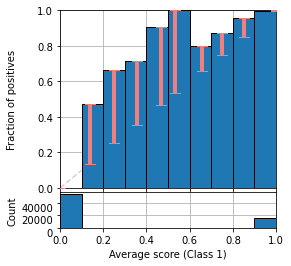

In [84]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_xgb_sigm, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

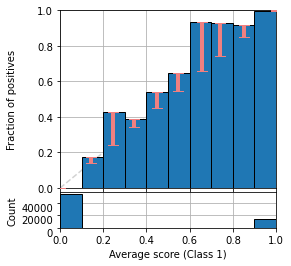

In [85]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_xgb_sigm_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)